# Evasion Attacks against Machine Learning

In this tutorial we will experiment with **adversarial evasion attacks**
 against a Support Vector Machine (SVM) with the Radial Basis Function (RBF) kernel.

Evasion attacks (a.k.a. *adversarial examples*) consists of carefully perturbing
the input samples at *test time* to have them misclassified.

We will first create and train the classifier, evaluating its performance
 in the standard scenario, *i.e. not under attack*.

The following part replicates the procedure from the [first tutorial](01-Training.ipynb).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/pralab/secml/blob/HEAD/tutorials/03-Evasion.ipynb)

In [1]:
%%capture --no-stderr --no-display
# NBVAL_IGNORE_OUTPUT

try:
  import secml
except ImportError:
  %pip install git+https://github.com/pralab/secml

In [2]:
random_state = 999

n_features = 2  # Number of features
n_samples = 1100  # Number of samples
centers = [[-2, 0], [2, -2], [2, 2]]  # Centers of the clusters
cluster_std = 0.8  # Standard deviation of the clusters

from secml.data.loader import CDLRandomBlobs
dataset = CDLRandomBlobs(n_features=n_features,
                         centers=centers,
                         cluster_std=cluster_std,
                         n_samples=n_samples,
                         random_state=random_state).load()

n_tr = 1000  # Number of training set samples
n_ts = 100  # Number of test set samples

# Split in training and test
from secml.data.splitter import CTrainTestSplit
splitter = CTrainTestSplit(
    train_size=n_tr, test_size=n_ts, random_state=random_state)
tr, ts = splitter.split(dataset)

# Normalize the data
from secml.ml.features import CNormalizerMinMax
nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X)
ts.X = nmz.transform(ts.X)

# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()

# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierSVM
from secml.ml.classifiers.multiclass import CClassifierMulticlassOVA
from secml.ml.kernels import CKernelRBF
clf = CClassifierMulticlassOVA(CClassifierSVM, kernel=CKernelRBF())

# Parameters for the Cross-Validation procedure
xval_params = {'C': [1e-2, 0.1, 1], 'kernel.gamma': [10, 100, 1e3]}

# Let's create a 3-Fold data splitter
from secml.data.splitter import CDataSplitterKFold
xval_splitter = CDataSplitterKFold(num_folds=3, random_state=random_state)

# Select and set the best training parameters for the classifier
print("Estimating the best training parameters...")
best_params = clf.estimate_parameters(
    dataset=tr,
    parameters=xval_params,
    splitter=xval_splitter,
    metric='accuracy',
    perf_evaluator='xval'
)

print("The best training parameters are: ",
      [(k, best_params[k]) for k in sorted(best_params)])

# We can now fit the classifier
clf.fit(tr.X, tr.Y)

# Compute predictions on a test set
y_pred = clf.predict(ts.X)

# Evaluate the accuracy of the classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)

print("Accuracy on test set: {:.2%}".format(acc))

2024-11-30 13:57:20,631 - secml.settings - INFO - New `SECML_HOME_DIR` created: /root/secml-data
2024-11-30 13:57:20,631 - secml.settings - INFO - New `SECML_HOME_DIR` created: /root/secml-data


INFO:secml.settings:New `SECML_HOME_DIR` created: /root/secml-data


2024-11-30 13:57:20,654 - secml.settings - INFO - Default configuration file copied to: /root/secml-data/secml.conf
2024-11-30 13:57:20,654 - secml.settings - INFO - Default configuration file copied to: /root/secml-data/secml.conf


INFO:secml.settings:Default configuration file copied to: /root/secml-data/secml.conf


2024-11-30 13:57:20,672 - secml.settings - INFO - New `SECML_DS_DIR` created: /root/secml-data/datasets
2024-11-30 13:57:20,672 - secml.settings - INFO - New `SECML_DS_DIR` created: /root/secml-data/datasets


INFO:secml.settings:New `SECML_DS_DIR` created: /root/secml-data/datasets


2024-11-30 13:57:20,694 - secml.settings - INFO - New `SECML_MODELS_DIR` created: /root/secml-data/models
2024-11-30 13:57:20,694 - secml.settings - INFO - New `SECML_MODELS_DIR` created: /root/secml-data/models


INFO:secml.settings:New `SECML_MODELS_DIR` created: /root/secml-data/models


2024-11-30 13:57:20,700 - secml.settings - INFO - New `SECML_EXP_DIR` created: /root/secml-data/experiments
2024-11-30 13:57:20,700 - secml.settings - INFO - New `SECML_EXP_DIR` created: /root/secml-data/experiments


INFO:secml.settings:New `SECML_EXP_DIR` created: /root/secml-data/experiments


2024-11-30 13:57:20,707 - secml.settings - INFO - New `SECML_LOGS_DIR` created: /root/secml-data/logs
2024-11-30 13:57:20,707 - secml.settings - INFO - New `SECML_LOGS_DIR` created: /root/secml-data/logs


INFO:secml.settings:New `SECML_LOGS_DIR` created: /root/secml-data/logs


2024-11-30 13:57:20,715 - secml.settings - INFO - New `SECML_PYTORCH_DIR` created: /root/secml-data/pytorch-data
2024-11-30 13:57:20,715 - secml.settings - INFO - New `SECML_PYTORCH_DIR` created: /root/secml-data/pytorch-data


INFO:secml.settings:New `SECML_PYTORCH_DIR` created: /root/secml-data/pytorch-data


Estimating the best training parameters...
The best training parameters are:  [('C', 0.1), ('kernel.gamma', 100)]
Accuracy on test set: 99.00%


## Crafting Adversarial Examples

We are going to create an adversarial example against the SVM classifier
 using the **gradient-based maximum-confidence** algorithm for generating
 evasion attacks proposed in:

  > [[biggio13-ecml]](https://arxiv.org/abs/1708.06131)
  > Biggio, B., Corona, I., Maiorca, D., Nelson, B., Šrndić, N., Laskov, P.,
  > Giacinto, G., Roli, F., 2013. Evasion Attacks against Machine Learning at
  > Test Time. In ECML-PKDD 2013.

  > [[melis17-vipar]](https://arxiv.org/abs/1708.06939)
  > Melis, M., Demontis, A., Biggio, B., Brown, G., Fumera, G. and
  > Roli, F., 2017. Is deep learning safe for robot vision? adversarial examples
  > against the icub humanoid. In Proceedings of IEEE ICCV 2017.

  > [[demontis19-usenix]](
  > https://www.usenix.org/conference/usenixsecurity19/presentation/demontis)
  > Demontis, A., Melis, M., Pintor, M., Jagielski, M., Biggio, B., Oprea, A.,
  > Nita-Rotaru, C. and Roli, F., 2019. Why Do Adversarial Attacks Transfer?
  > Explaining Transferability of Evasion and Poisoning Attacks. In 28th Usenix
  > Security Symposium, Santa Clara, California, USA.

which is implemented in SecML by the `CAttackEvasionPGDLS` class.

Let's define the attack parameters. First, we choose to generate an *l2*
 perturbation within a maximum ball of radius `eps = 0.4` from the initial
 point. The maximum perturbation value is denoted as `dmax` in our
 implementation. Second, we also add a low/upper bound as our feature space
 is limited in `[0, 1]`. Last, as we are not interested in generating an
 adversarial example for a specific class, we perform an error-generic attack
 by setting `y_target = None`.

The attack internally uses a solver based on *Projected Gradient Descent
 with Bisect Line Search*, implemented by the `COptimizerPGDLS` class.
 The parameters of the solver can be specified while creating the attack
 and must be optimized depending on the specific optimization problem.

In [3]:
x0, y0 = ts[5, :].X, ts[5, :].Y  # Initial sample

noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
dmax = 0.4  # Maximum perturbation
lb, ub = 0, 1  # Bounds of the attack space. Can be set to `None` for unbounded
y_target = None  # None if `error-generic` or a class label for `error-specific`

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.3,
    'eta_min': 0.1,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-4
}

from secml.adv.attacks.evasion import CAttackEvasionPGDLS
pgd_ls_attack = CAttackEvasionPGDLS(
    classifier=clf,
    double_init_ds=tr,
    double_init=False,
    distance=noise_type,
    dmax=dmax,
    lb=lb, ub=ub,
    solver_params=solver_params,
    y_target=y_target)

# Run the evasion attack on x0
y_pred_pgdls, _, adv_ds_pgdls, _ = pgd_ls_attack.run(x0, y0)

print("Original x0 label: ", y0.item())
print("Adversarial example label (PGD-LS): ", y_pred_pgdls.item())

print("Number of classifier gradient evaluations: {:}"
      "".format(pgd_ls_attack.grad_eval))

Original x0 label:  1
Adversarial example label (PGD-LS):  2
Number of classifier gradient evaluations: 7


Let's now test another attack algorithm, implemented by `CAttackEvasionPGD`,
 which leverages the standard *Projected Gradient Descent* solver.
 We keep the same attack parameters as before.

In [4]:
# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.3,
    'max_iter': 100,
    'eps': 1e-4
}

from secml.adv.attacks.evasion import CAttackEvasionPGD
pgd_attack = CAttackEvasionPGD(
    classifier=clf,
    double_init_ds=tr,
    double_init=False,
    distance=noise_type,
    dmax=dmax,
    lb=lb, ub=ub,
    solver_params=solver_params,
    y_target=y_target)

# Run the evasion attack on x0
y_pred_pgd, _, adv_ds_pgd, _ = pgd_attack.run(x0, y0)

print("Original x0 label: ", y0.item())
print("Adversarial example label (PGD): ", y_pred_pgd.item())

print("Number of classifier gradient evaluations: {:}"
      "".format(pgd_attack.grad_eval))


Original x0 label:  1
Adversarial example label (PGD):  2
Number of classifier gradient evaluations: 40


We can see that the classifier has been successfully evaded in both cases.
 However, the `PGD-LS` solver with bisect line search queries the classifier
 gradient function many times less, thus generating the
 adversarial examples much faster.

Let's now visualize both the attacks on a 2D plane. On the background, the
 value of the objective function of the attacks is shown.

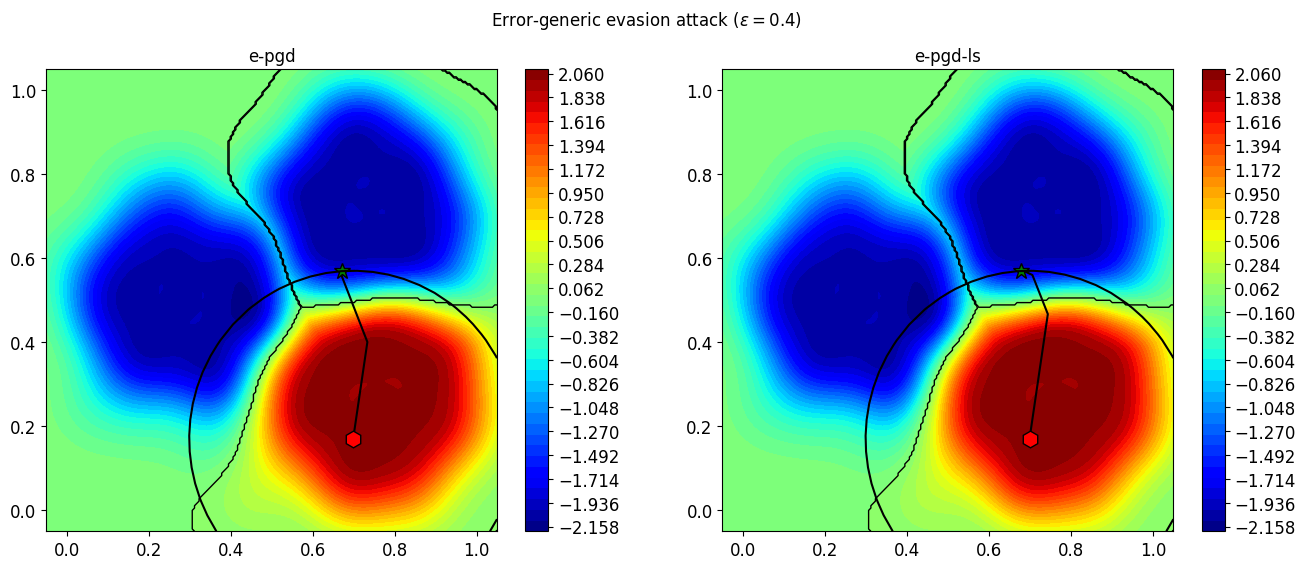

In [5]:
from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(width=16, height=6, markersize=12)

# Let's replicate the `l2` constraint used by the attack for visualization
from secml.optim.constraints import CConstraintL2
constraint = CConstraintL2(center=x0, radius=dmax)

for i, (attack, adv_ds) in enumerate(
        [(pgd_attack, adv_ds_pgd), (pgd_ls_attack, adv_ds_pgdls)]):

    fig.subplot(1, 2, i + 1)

    # Convenience function for plotting the attack objective function
    fig.sp.plot_fun(attack.objective_function, plot_levels=False,
                    multipoint=True, n_grid_points=200)
    # Let's also plot the decision boundaries of the classifier
    fig.sp.plot_decision_regions(clf, plot_background=False, n_grid_points=200)

    # Construct an array with the original point and the adversarial example
    adv_path = x0.append(adv_ds.X, axis=0)

    # Convenience function for plotting the optimization sequence
    fig.sp.plot_path(attack.x_seq)

    # Convenience function for plotting a constraint
    fig.sp.plot_constraint(constraint)

    fig.sp.title(attack.class_type)
    fig.sp.grid(grid_on=False)

fig.title(r"Error-generic evasion attack ($\varepsilon={:}$)".format(dmax))

fig.show()

We can see that the initial point **x0** (red hexagon) has been perturbed
 in the feature space so that is actually classified by the SVM as a point
 from another class. The final *adversarial example* is the green star.
 We also show the *l2* constraint as a black circle which has limited the
 maximum perturbation applicable to **x0**.

## Security evaluation of a classifier

We could be interested in evaluating the **robustness** of a classifier
 against increasing values of the maximum perturbation `eps`.

SecML provides a way to easily produce a **Security Evaluation Curve**,
 by means of the `CSecEval` class.

The `CSecEval` instance will take a `CAttack` as input and will test the
 classifier using the desired perturbation levels.

*Please note that the security evaluation process may take a while
 (up to a few minutes) depending on the machine the script is run on.*

Running security evaluation...


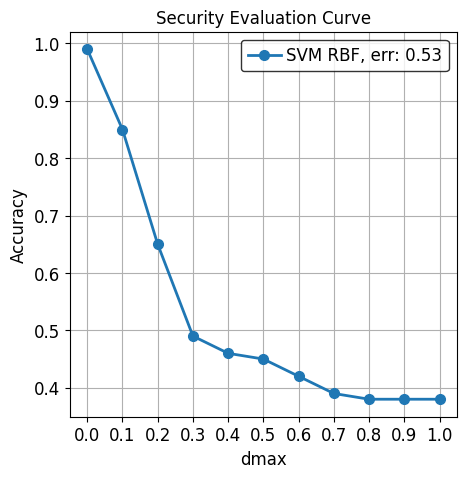

In [6]:
# Perturbation levels to test
from secml.array import CArray
e_vals = CArray.arange(start=0, step=0.1, stop=1.1)

from secml.adv.seceval import CSecEval
sec_eval = CSecEval(
    attack=pgd_ls_attack, param_name='dmax', param_values=e_vals)

# Run the security evaluation using the test set
print("Running security evaluation...")
sec_eval.run_sec_eval(ts)

from secml.figure import CFigure
fig = CFigure(height=5, width=5)

# Convenience function for plotting the Security Evaluation Curve
fig.sp.plot_sec_eval(
    sec_eval.sec_eval_data, marker='o', label='SVM RBF', show_average=True)

We can see how the SVM classifier is *vulnerable* to adversarial attacks
 and we are able to evade it even with small perturbations.

For further reference about the security evaluation of machine-learning models
 under attack see:

  > [[biggio13-tkde]](https://arxiv.org/abs/1709.00609)
  > Biggio, B., Fumera, G. and Roli, F., 2013. Security evaluation of pattern
  > classifiers under attack. In IEEE transactions on knowledge and data
  > engineering.

  > [[biggio18-pr]](https://arxiv.org/abs/1712.03141)
  > Biggio, B. and Roli, F., 2018. Wild patterns: Ten years after the rise of
  > adversarial machine learning. In Pattern Recognition.
